# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
import torch
from torch import nn, optim
from torch.utils import data
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from workspace_utils import keep_awake
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
transforms_training = transforms.Compose([transforms.RandomRotation(30),
                                               transforms.RandomResizedCrop(224), 
                                               transforms.RandomHorizontalFlip(), 
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transforms_testing = transforms.Compose([transforms.Resize(255),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset_training = datasets.ImageFolder(train_dir, transform=transforms_training)
dataset_validation = datasets.ImageFolder(valid_dir, transform=transforms_testing)
dataset_testing = datasets.ImageFolder(test_dir, transform=transforms_testing)

dataloaders_training = data.DataLoader(dataset_training, batch_size=64, shuffle=True)
dataloaders_validation = data.DataLoader(dataset_validation, batch_size=64)
dataloaders_testing = data.DataLoader(dataset_testing, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
def train_network(model, optimizer, criterion, epochs):
    ''' Trains the assigned model with the desired parameters. Ensures automatic transfer
        of model to the GPU if available.
        After each training run model metrics are printed to standard out.
    '''
    training_losses, validation_losses = [], []

    # ensure gpu is used if available    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()
    
    for epoch in keep_awake(range(epochs)):
        running_loss = 0

        for images, labels in dataloaders_training:
            # runs training on passed model with pre-defined training dataset
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        else: 
            # runs validation after each epoch and prints out loss and accuracy metrics
            model.eval()
            validation_loss = 0
            accuracy = 0

            with torch.no_grad():
                for images_validation, labels_validation in dataloaders_validation:
                    images_validation, labels_validation = images_validation.to(device), labels_validation.to(device)

                    output = model.forward(images_validation)
                    loss = criterion(output, labels_validation)
                    validation_loss += loss.item()

                    p = torch.exp(output)
                    top_p, top_class = p.topk(1, dim=1)
                    batch_accucary = top_class == labels_validation.view(*top_class.shape)
                    accuracy += torch.mean(batch_accucary.type(torch.FloatTensor)).item()

            training_losses.append(running_loss/len(dataloaders_training))
            validation_losses.append(validation_loss/len(dataloaders_validation))

            model.train()

            print('Epoch: {}/{},\t Testing Loss: {},\t Validation Loss: {}, \t Accuracy: {}'.format(epoch+1, epochs, 
                                                                                          running_loss/len(dataloaders_training),
                                                                                          validation_loss/len(dataloaders_validation),
                                                                                          accuracy/len(dataloaders_validation))) 
    model.eval()
    model.to('cpu')
    return training_losses, validation_losses

In [6]:
def plot_losses(training_losses, validation_losses):
    ''' 
    Plots a graph comparing the training and validation losses. With that, overfitting can be detected.
    '''
    plt.plot(training_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend(frameon=False)

In [7]:
# Defines classifier for this project. Expects 25088 features as input based on the vgg16 classifier definition
class ImageClassifier(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
            
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, output_size)
        self.dropout = nn.Dropout(p=0.2)
        
        # init properties that can be set after initialization manually
        self.optimizer_state_dict = None
        self.criterion = None
        self.class_idx_mapping = None
        self.epochs = None
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

# download pre-trained model and freeze layers
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# create custom image classifier and metrics for model learning    
input_size = 25088
hidden_layer_size = 1024
output_size = 102

model.classifier = ImageClassifier(input_size, hidden_layer_size, output_size)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:14<00:00, 38391499.24it/s]


In [8]:
# execute model training
num_epochs = 1
training_losses, validation_losses = train_network(model, optimizer, criterion, epochs=num_epochs)

# plotting disabled => run with up to 10 epochs didn't show sign of overfitting, accuracy however
# declined on test set with increasing amount of epochs for training. Training with 1 epoch was sufficient for accuracy values of over 80%
# plot_losses(training_losses, validation_losses)

Epoch: 1/1,	 Testing Loss: 2.3604899679572835,	 Validation Loss: 0.6990018922549027, 	 Accuracy: 0.8223557701477637


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
def test_network(model, criterion):
    ''' Uses assigned model to run test data set and prints metrics.'''
    # ensure gpu is used if available    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    testing_loss = 0
    accuracy = 0

    with torch.no_grad():
        for images, labels in dataloaders_testing:
            images, labels = images.to(device), labels.to(device)

            output = model.forward(images)
            loss = criterion(output, labels)
            testing_loss += loss.item()

            p = torch.exp(output)
            top_p, top_class = p.topk(1, dim=1)
            batch_accucary = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(batch_accucary.type(torch.FloatTensor)).item()

    print('Values on test set')
    print('Testing loss: {},\t Accuracy: {}'.format(accuracy/len(dataloaders_testing), 
                                                    testing_loss/len(dataloaders_testing)))

In [10]:
# run testing data on trained model
test_network(model, criterion)

Values on test set
Testing loss: 0.7471719475892874,	 Accuracy: 0.8545674280478404


One training run seems to be sufficient to train the network to recognize the flowers with an accuracy of ~86% as can be seen in the previous cell.

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
checkpoint_path = 'model_checkpoint.pth'

checkpoint = {'input_size': input_size,
              'hidden_layer_size': hidden_layer_size,
              'output_size': output_size,
              'state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'criterion': criterion,
              'class_idx_mapping': dataset_training.class_to_idx,
              'epochs': num_epochs}

In [12]:
model.cpu()

torch.save(checkpoint, checkpoint_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [13]:
def load_model_from_checkpoint(path):
    ''' Loads vgg16 model from provided file path with customized classifier for flower classification.'''
    checkpoint = torch.load(path)
    model = models.vgg16()
    model.classifier = ImageClassifier(checkpoint['input_size'],
                 checkpoint['hidden_layer_size'],
                 checkpoint['output_size'])
    model.load_state_dict(checkpoint['state_dict'])
    
    # register additional parameters in case model is used for further training
    model.classifier.epochs = checkpoint['epochs']
    model.classifier.class_idx_mapping = checkpoint['class_idx_mapping']
    model.classifier.optimizer_state_dict = checkpoint['optimizer_state_dict']
    model.classifier.criterion = checkpoint['criterion']
        
    return model

In [14]:
# sanity check: check whether prediction works with loaded model and gives the same result
model_loaded = load_model_from_checkpoint(checkpoint_path)
test_network(model_loaded, criterion)

Values on test set
Testing loss: 0.7471719475892874,	 Accuracy: 0.8545674280478404


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

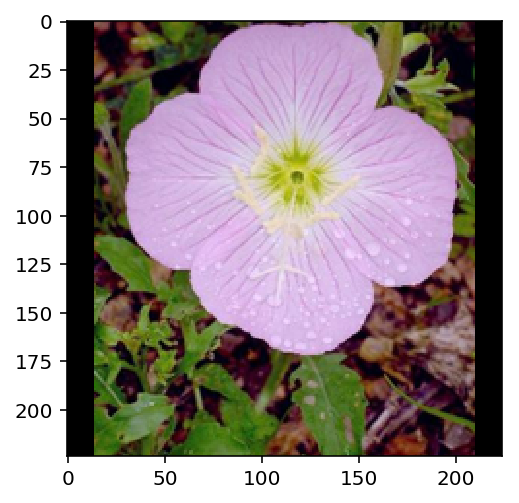

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    image.thumbnail((256, 256))
    
    new_size = 224
    left = (image.size[0] - new_size) / 2
    upper = (image.size[1] - new_size) / 2
    right = (image.size[0] + new_size) / 2
    lower = (image.size[1] + new_size) / 2
    
    cropped = image.crop((left, upper, right, lower))
    
    # adjust color channel features
    np_image = np.array(cropped)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    np_image = (np_image - mean) / std
    np_image = np_image.transpose(2, 0, 1)

    return torch.from_numpy(np_image)


image_path = 'flowers/train/1/image_06741.jpg'
image_raw = Image.open(image_path)
image = process_image(image_raw)

imshow(image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [16]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [34]:
def predict(image_path, model_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image_raw = Image.open(image_path)
    image = process_image(image_raw).unsqueeze(0).type(torch.FloatTensor)

    model = load_model_from_checkpoint(model_path)
    model.eval()
    
    output = model.forward(image)    
    
    p = torch.exp(output)
    top_p, top_class = p.topk(topk, dim=1)
    
    # create labels for predicted classes
    class_idx_mapping = model.classifier.class_idx_mapping
    idx_to_class = { v:k for (k, v) in class_idx_mapping.items() }
    
    class_list = []
    for flower_class in top_class.squeeze(0).tolist():
        class_list.append(cat_to_name[idx_to_class[flower_class]])
    
    return top_p, class_list

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

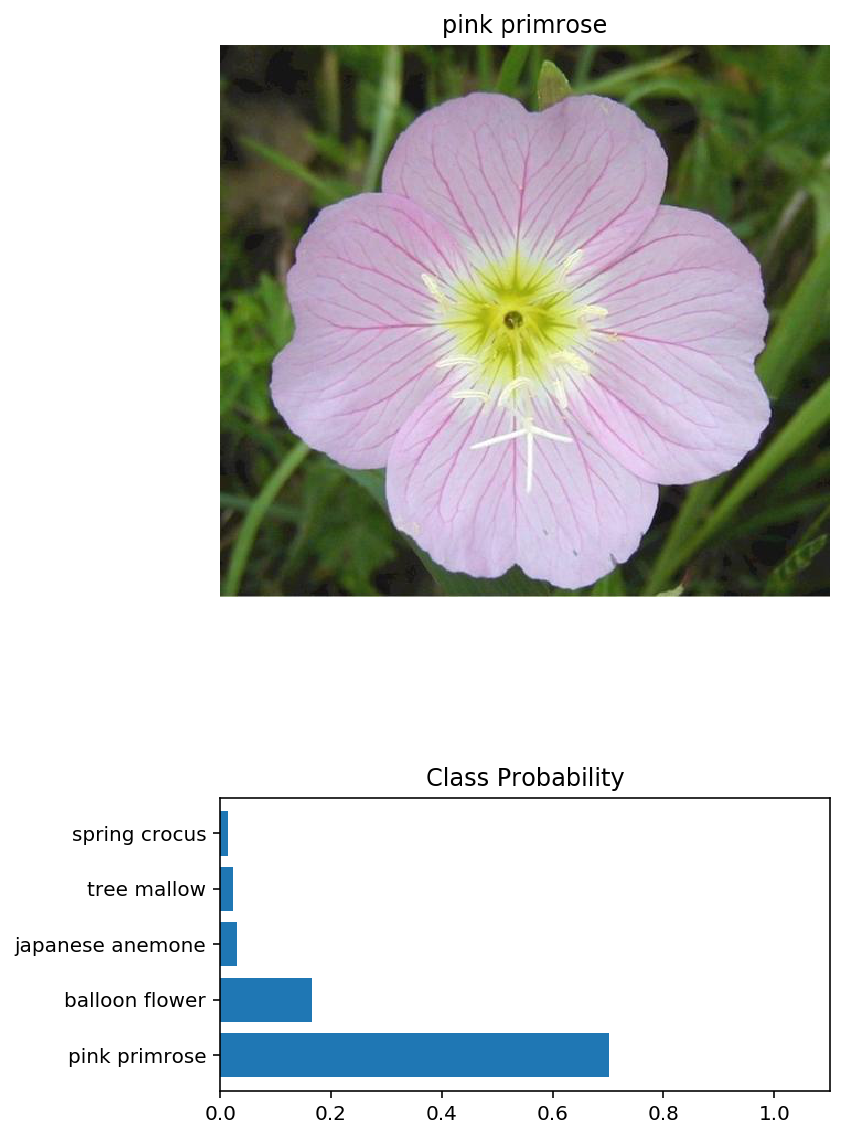

In [35]:
def plot(img, ps, classes):
    ''' Function for viewing an image and it's predicted classes.'''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)
    ax1.imshow(img)
    ax1.set_title(classes[0])
    ax1.axis('off')
    ax2.set_aspect(0.1)
    ax2.barh(np.arange(len(classes)), top_p.squeeze(0).tolist())
    ax2.set_yticks(np.arange(len(classes)))
    ax2.set_yticklabels(classes);
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


image_path = 'flowers/train/1/image_06742.jpg'
checkpoint_path = 'model_checkpoint.pth'
top_p, top_class = predict(image_path, checkpoint_path, topk=5)
image = Image.open(image_path)

plot(image, top_p, top_class)